In [1]:
%matplotlib notebook
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import scipy.signal
import datetime
from collections import Counter
from scipy.ndimage.filters import gaussian_filter,gaussian_filter1d
pd.set_option('display.max_rows', 1000)

def bold(obj):
    return fr"$\bf{{{obj}}}$"

In [2]:
path = './results/experiment2_2'
count = 0

src_migrations = []
for i in range(len(os.listdir(os.path.join(path, 'src_migrations')))):
    with open(os.path.join(path, 'src_migrations', f'out_{i}.log'), 'r') as f:
        src_migrations.append(iter(f.read().splitlines()))

src_headers = []
for i in range(len(os.listdir(os.path.join(path, 'src_headers')))):
    with open(os.path.join(path, 'src_headers', f'nsgaii_results_{i}.csv'), 'r') as f:
        src_headers.append(iter(f.read().splitlines()))
        
for injects in [1.0]:
    for evals in [10, 30, 60]:
        for pop_size in [10, 40, 102]:
            for num_mobiles in [60]:
                for migration_type in [1, 2, 3, 4, 5, 6]:
                    migrations = []
                    src_file = src_migrations[count % len(src_migrations)]
                    
                    while (l := next(src_file, 'Migrations')) != 'Migrations':
                        pass
                    
                    while (l := next(src_file, '')) != '':
                        migrations.append(l)
                    
                    if not migrations:
                        migrations.append('03:00:00 ?')
                        migrations.append('03:59:00 ?')

                    header = next(src_headers[count % len(src_headers)], f'{num_mobiles}\t{pop_size}\t{evals}\t100\t?\t?\t?\t?').split('\t')
                    
                    assert pop_size == int(header[1])
                    assert evals == int(header[2])
                    
                    new_header = f'{migration_type}, {pop_size}, {evals}, {header[4]}, {header[-1]}'  
                    
                    with open(os.path.join(path, 'out', f'./{"0" if count < 10 else ""}{count}_{migration_type}_{pop_size}_{evals}'), 'w') as f:
                        f.write(new_header + '\n')
                        f.write('\n'.join(migrations))
                    count += 1


In [3]:
path = './results/experiment2_2/out'
dateformat = '%H:%M:%S'
all_data = {}
for fn in os.listdir(path):
    with open(os.path.join(path, fn), 'r') as f:
        migrations = f.read().splitlines()
        all_data[migrations[0]] = [(datetime.datetime.strptime(s[:8], dateformat) - datetime.datetime(1900, 1, 1, hour=3)).total_seconds() for s in migrations[1:]]
    
grouped = {}

for key, times in all_data.items():
    time, count = np.unique(times, return_counts=True)
    grouped[key] = (time, count)

<IPython.core.display.Javascript object>


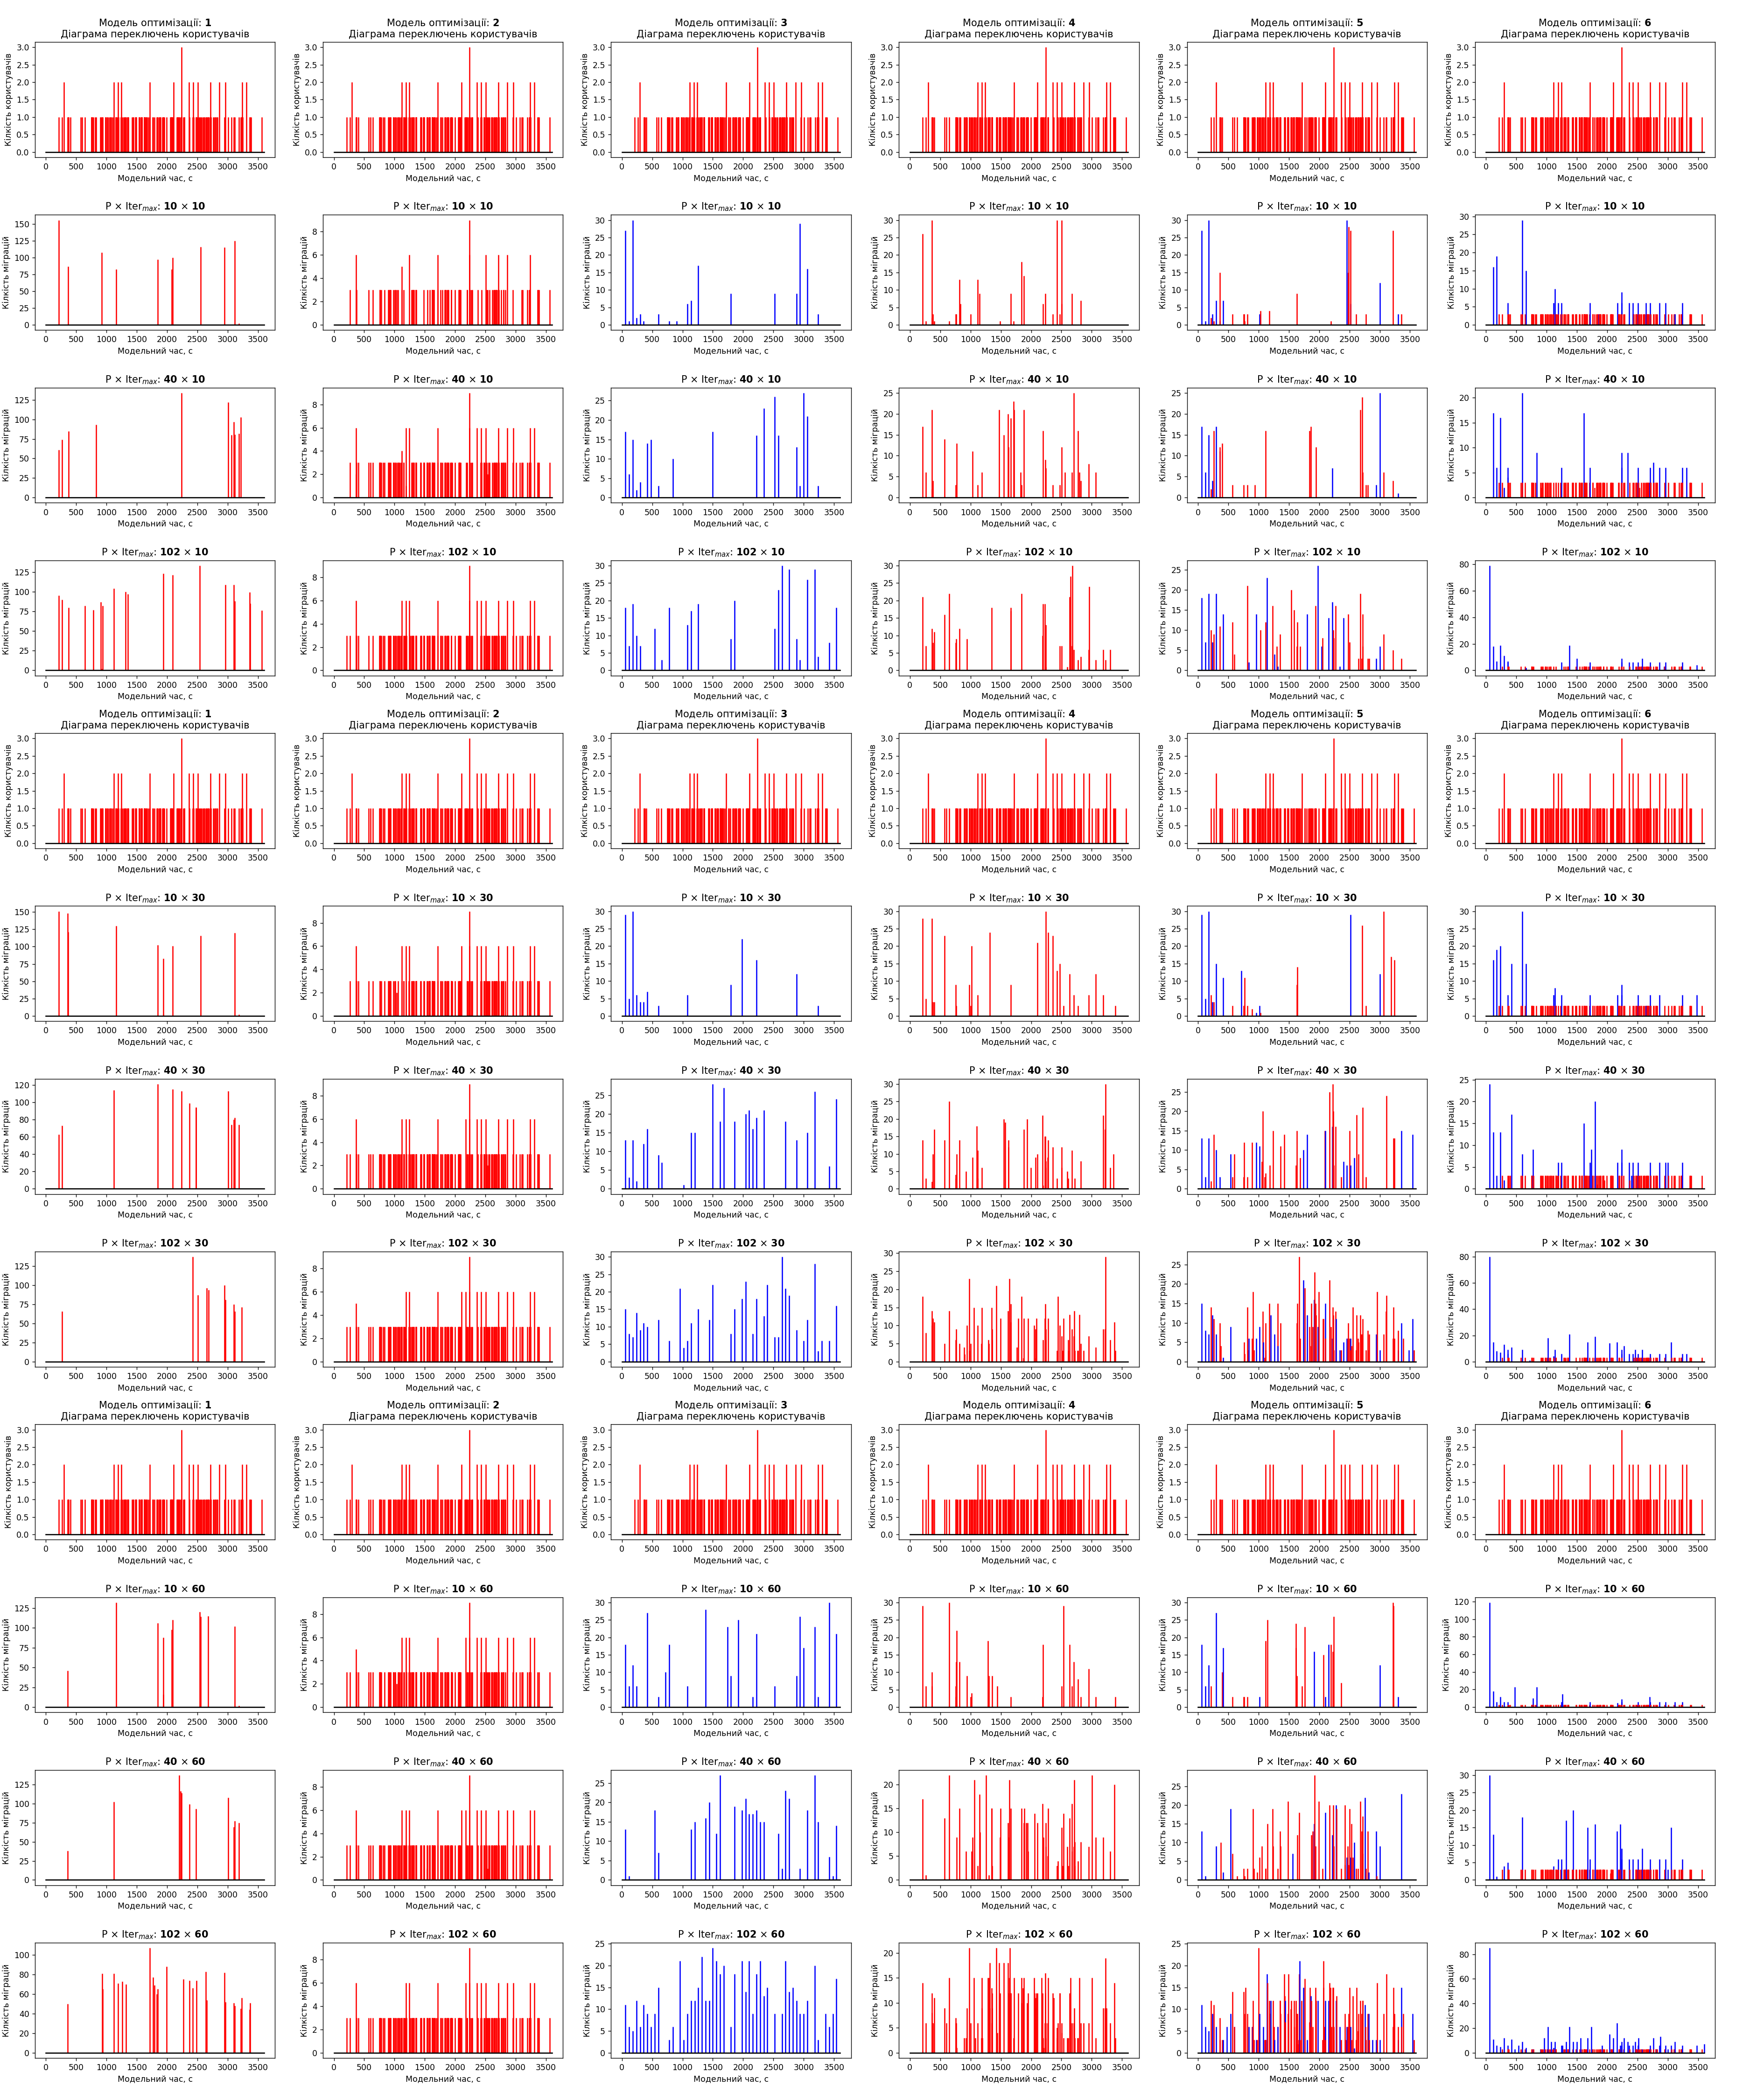

In [4]:
total_plots = len(grouped)
fig, axs = plt.subplots(total_plots//6, 6, figsize=(6*5, 0.5 * total_plots))
axs = axs.reshape(-1)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.5)
for i, (key, (times, counts)) in enumerate(grouped.items()):
    mod_type, pop_size, max_iter, delay, exec_time = key.split(', ')
    markerline, stemlines, baseline = axs[i].stem(np.hstack(([0], times[1:], [3600])), np.hstack(([0], counts[1:], [0])))
    baseline.set_color('black')
    colors = np.array([[0,0,1]] * (len(times) - 1))
    if int(mod_type) in [1, 2, 4, 5, 6] or exec_time == 'handoff':
        bs_events_times = grouped[f'{mod_type}, 60, 0, 0, handoff'][0][1:]
        bs_events_indices = np.isin(times[1:], bs_events_times)
        if int(mod_type) == 6:
            colors[bs_events_indices & (counts[1:] <= 3)] = [1,0,0]
        else:
            colors[bs_events_indices] = [1,0,0]
    colors = np.vstack(([[0,0,0]], colors, [[0,0,0]]))
    stemlines.set_color(colors)
    markerline.set_color('black')
    markerline.set_marker(None)
    if exec_time == 'handoff':
        axs[i].set_title(f'Модель оптимізації: {bold(mod_type)}\nДіаграма переключень користувачів')
        axs[i].set_xlabel('Модельний час, с')
        axs[i].set_ylabel('Кілкість користувачів')
    else:
        axs[i].set_title('P $\\times$ Iter$_{max}$: ' + f'{bold(pop_size)} $\\times$ {bold(max_iter)}')
        axs[i].set_xlabel('Модельний час, с')
        axs[i].set_ylabel('Кілкість міграцій')
        
fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.2, hspace=0.5)

<IPython.core.display.Javascript object>


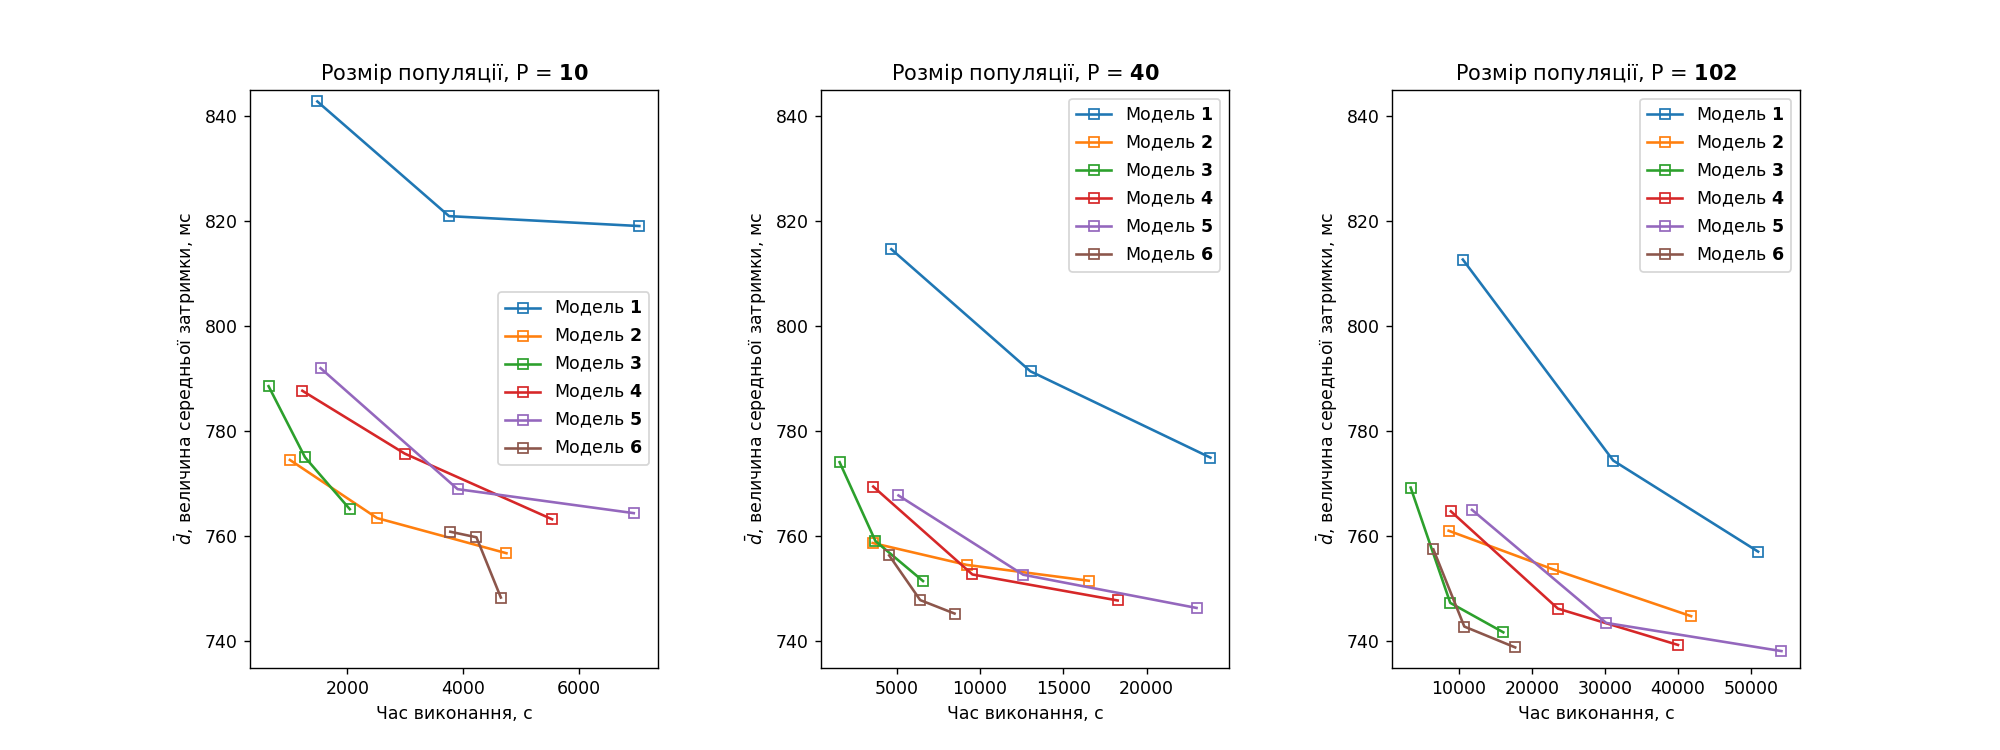

In [5]:
split = [key.split(', ') for key in grouped]
data = [[float(v.replace(',', '.')) if v.replace(',', '', 1).isdigit() else float('nan') for v in tup] for tup in split]
df = pd.DataFrame(data, columns=['mod_type', 'pop_size', 'max_iter', 'delay', 'exec_time'])
df = df.dropna()
df = df.sort_values(['mod_type', 'delay'])
fig = plt.figure(figsize=(16, 6))
total_plots = len(df.groupby('pop_size'))
count = 0
for pop_size, df_gr1 in df.groupby('pop_size'):
    ax = fig.add_subplot(1, total_plots, count + 1)
    count += 1
    for mod_type, df_gr2 in df_gr1.groupby('mod_type'):
        df_gr2 = df_gr2.sort_values('exec_time')
        x = df_gr2['exec_time'].to_numpy()
        y = df_gr2['delay'].to_numpy()
        ax.plot(x,y, label=f'Модель {bold(int(mod_type))}', marker='s', fillstyle='none')
        ax.set_title(f'Розмір популяції, P = {bold(int(pop_size))}')
        ax.set_xlabel('Час виконання, с')
        ax.set_ylabel('$\\bar{d}$, величина середньої затримки, мс')
    ax.set_ylim(735, 845)
    ax.legend()
fig.subplots_adjust(wspace=0.4)